# Advanced Lane Finding

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os 

%matplotlib inline 

## Camera Calibration

In [2]:
def get_image_with_corners(image, nx_ny):
    image2 = np.copy(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, nx_ny, None)
    if ret:
        cv2.drawChessboardCorners(image2, nx_ny, corners, ret)
    return image2

In [3]:
camera_cal_images = []
for filename in glob.glob('camera_cal/*.jpg'):
    camera_cal_images.append(mpimg.imread(filename))

In [4]:
objpoints = []
imgpoints = []

In [5]:
objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

In [6]:
img_shape = camera_cal_images[0].shape[0:2]

In [7]:
nx = 9
ny = 6

for img in camera_cal_images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

In [8]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_shape[::-1], None, None)

### Example of correction for distortion

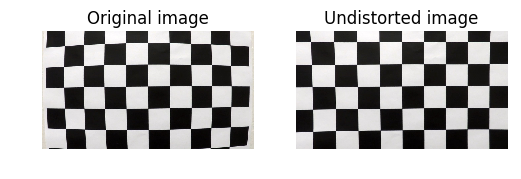

In [9]:
image = camera_cal_images[0]
undist = cv2.undistort(camera_cal_images[0], mtx, dist, None, mtx)

fig = plt.figure()

fig.add_subplot(121)
plt.imshow(image)
plt.title('Original image')
plt.axis('off')

fig.add_subplot(122)
plt.imshow(undist)
plt.title('Undistorted image')
plt.axis('off')

plt.show()

fig.savefig('output_images/example_undist.jpg', bbox_inches='tight')

## Correction for Distortion

In [10]:
for filename in glob.glob('test_images/*.jpg'):
    new_filename = 'output_images/' + os.path.basename(filename)
    img = mpimg.imread(filename)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    mpimg.imsave(new_filename, dst)

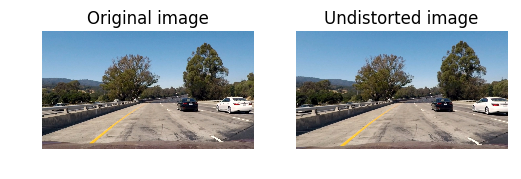

In [11]:
test_image   = mpimg.imread('test_images/test1.jpg')
undist_image = mpimg.imread('output_images/test1.jpg')

fig = plt.figure()

fig.add_subplot(121)
plt.imshow(test_image)
plt.title('Original image')
plt.axis('off')

fig.add_subplot(122)
plt.imshow(undist_image)
plt.title('Undistorted image')
plt.axis('off')

plt.show()

fig.savefig('output_images/example_undist_test_images.jpg', bbox_inches='tight')

## Lane detection

### Functions

In [12]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [13]:
def get_line_centers(histogram):
    mid   = np.int(histogram.shape[0]/2)
    left  = np.argmax(histogram[:mid])
    right = np.argmax(histogram[mid:]) + mid
    return left, right

In [14]:
def get_line(image, center, window = 50, line_width = 10):
    line = np.zeros_like(image)
    min_width = 0
    max_width = image.shape[1] - 1
    for i in range(image.shape[0], 0, -1):
        row = i - 1
        sp = max(min_width, center - window)
        ep = min(max_width, center + window)
        if np.sum(image[row,sp:ep]) > 0:
            center = int(sp + np.mean(np.where(image[row,sp:ep] > 0)))
            l_side = max(min_width, center - line_width)
            r_side = min(max_width, center + line_width)
            line[row,l_side:r_side] = 1

    return line

In [15]:
def detect_white_line(image):
    lb = np.array([200, 200, 200])
    ub = np.array([255, 255, 255])
    line = cv2.inRange(image, lb, ub)
    binary = np.zeros(image.shape[0:2])
    binary[(line > 0)] = 1

    return binary

In [16]:
def detect_yellow_line(hsv):
    lb = np.array([ 0, 100, 200])
    ub = np.array([ 40, 255, 255])
    line   = cv2.inRange(hsv, lb, ub)               
    binary = np.zeros(hsv.shape[0:2])
    binary[(line > 0)] = 1
    return binary

In [17]:
def detect_lines(image):
    hsv    = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    binary = np.zeros(image.shape[0:2])
    yline  = detect_yellow_line(hsv)
    wline  = detect_white_line(image)
    
    binary[(yline == 1) | (wline == 1)] = 1

    return binary

In [18]:
def x_y(line):
    x = []
    y = []
    for i in range(line.shape[0]):
        points = np.where(line[i,:])
        if len(points[0]) > 0:
            x.append(np.int(np.mean(points[0])))
            y.append(i)
            
    return np.array(x), np.array(y)

In [19]:
def get_line_coefs(x, y):
    cfs = np.polyfit(y, x, 2)
    return cfs[::-1]

In [20]:
def fit_line(coefs, y):
    return coefs[0] + coefs[1]*y + coefs[2]*y**2

In [21]:
def get_line_curvature_coefs(x, y):
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    cfs = np.polyfit(y * ym_per_pix, x * xm_per_pix, 2)
    return cfs[::-1]

In [22]:
def get_curvature(coefs, y):
    return ((1 + (2*coefs[2]*y + coefs[1])**2)**1.5) / np.absolute(2*coefs[2])

In [23]:
def deviation_from_center(center, left, right, ndigits=2):
    return round(left + right - 2 * center, ndigits)

In [24]:
def pipeline(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image[:,:,0] = clahe.apply(image[:,:,0])
    image[:,:,1] = clahe.apply(image[:,:,1])
    image[:,:,2] = clahe.apply(image[:,:,2])
    
    img_size = (image.shape[1], image.shape[0])
    undist   = cv2.undistort(image, mtx, dist, None, mtx)
    vertices = np.array([[
        ( 150, 700),
        ( 580, 450), 
        ( 730, 450), 
        (1200, 700)
    ]], dtype=np.int32)

    masked = region_of_interest(detect_lines(undist), vertices)
    
    src = np.float32(((475, 548), (875, 548), (1200, 712), (250, 712)))
    dst = np.float32(((350, 600), (940, 600), (940, 720), (350, 720)))

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(masked, M, img_size)
    warped[warped > 0] = 1
    
    histogram = np.sum(warped[warped.shape[0]*0.7:,:], axis=0)
    
    ml, mr = get_line_centers(histogram)
    left_line  = get_line(warped, ml)
    right_line = get_line(warped, mr)

    yplot = np.array([x for x in range(image.shape[0])])

    lx, ly = x_y(left_line)
    coefs_l = get_line_coefs(lx, ly)
    xplot_l = fit_line(coefs_l, yplot)    

    rx, ry = x_y(right_line)
    coefs_r = get_line_coefs(rx, ry)
    xplot_r = fit_line(coefs_r, yplot)    

    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([xplot_l, yplot]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([xplot_r, yplot])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)    
    
    ccoefs_l = get_line_curvature_coefs(xplot_l, yplot)
    ccoefs_r = get_line_curvature_coefs(xplot_r, yplot)
    l_curv_text = "Curvature for left line:  {} meters".format(get_curvature(ccoefs_l, yplot[-1]))
    r_curv_text = "Curvature for rigth line: {} meters".format(get_curvature(ccoefs_r, yplot[-1]))
    dev_text    = "Deviation from center: {}".format(deviation_from_center(image.shape[1]/2, ml, mr))
    cv2.putText(result, l_curv_text, (50,45), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
    cv2.putText(result, r_curv_text, (50,70), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
    cv2.putText(result, dev_text, (50,95), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
    
    return result

## Example of undistorted image

In [25]:
image = mpimg.imread('output_images/test1.jpg')
img_size = (image.shape[1], image.shape[0])
plt.imshow(image)
plt.show()

## Clahe 

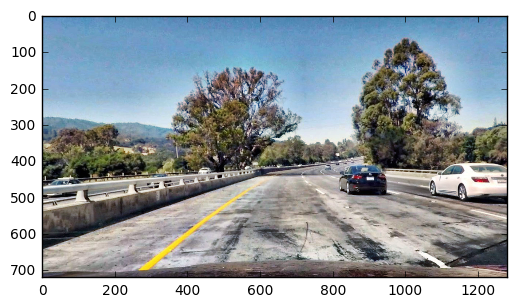

In [26]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
image[:,:,0] = clahe.apply(image[:,:,0])
image[:,:,1] = clahe.apply(image[:,:,1])
image[:,:,2] = clahe.apply(image[:,:,2])

plt.imshow(image)
plt.show()

## White Lines Detection

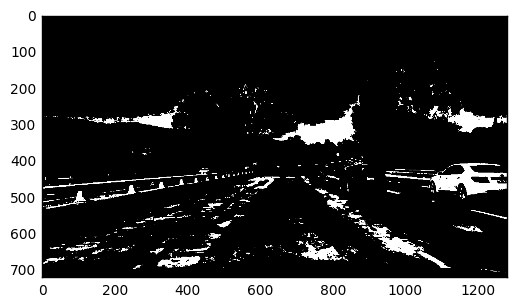

In [27]:
plt.imshow(detect_white_line(image), cmap='gray')
plt.show()

## Yellow Lines Detection

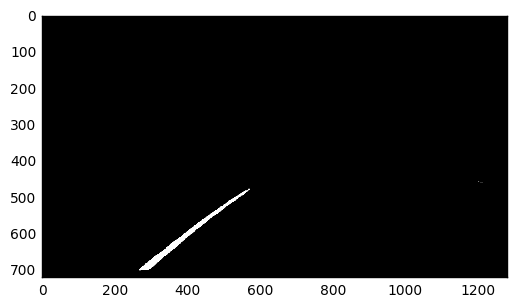

In [28]:
hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
plt.imshow(detect_yellow_line(hsv), cmap='gray')
plt.show()

## Combination of white and yellow lines

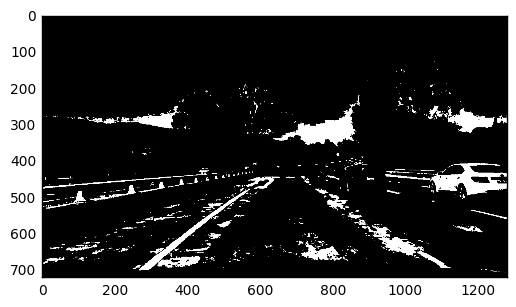

In [29]:
plt.imshow(detect_lines(image), cmap='gray')
plt.show()

## Region of Interest

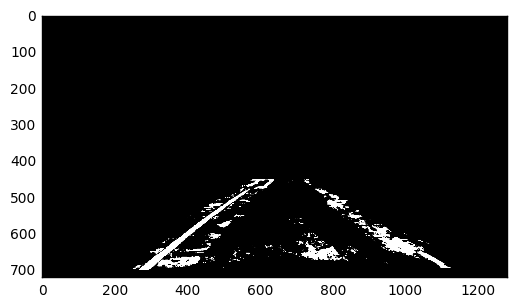

In [30]:
vertices = np.array([[
        ( 150, 700),
        ( 580, 450), 
        ( 730, 450), 
        (1200, 700)
    ]], dtype=np.int32)

masked = region_of_interest(detect_lines(image), vertices)

plt.imshow(masked, cmap='gray')
plt.show()

## Perspective Transformation

In [31]:
src = np.float32(((475, 548), (875, 548), (1200, 712), (250, 712)))
dst = np.float32(((350, 600), (940, 600), (940, 720), (350, 720)))

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

In [32]:
warped = cv2.warpPerspective(masked, M, img_size)
warped[warped > 0] = 1
plt.imshow(warped, cmap='gray')
plt.show()

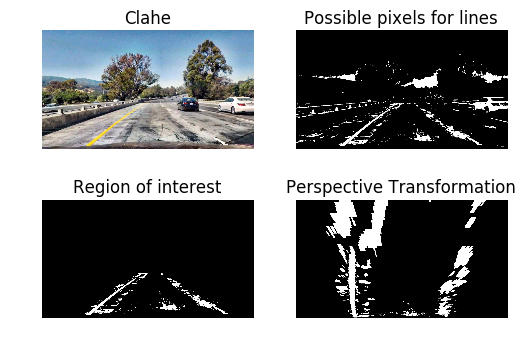

In [33]:
fig = plt.figure()

fig.add_subplot(221)
plt.imshow(image)
plt.title('Clahe')
plt.axis('off')

fig.add_subplot(222)
plt.imshow(detect_lines(image), cmap='gray')
plt.title('Possible pixels for lines')
plt.axis('off')

fig.add_subplot(223)
plt.imshow(masked, cmap='gray')
plt.title('Region of interest')
plt.axis('off')

fig.add_subplot(224)
plt.imshow(warped, cmap='gray')
plt.title('Perspective Transformation')
plt.axis('off')

plt.show()
fig.savefig('output_images/first_4_steps.jpg', bbox_inches='tight')

## Line Centers Detection and Line Recovery

/Users/Bombard/anaconda/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


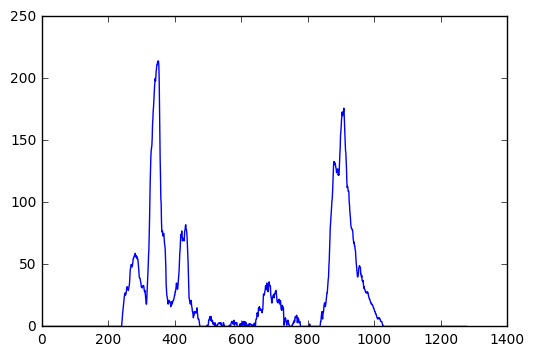

In [34]:
histogram = np.sum(warped[warped.shape[0]*0.7:,:], axis=0)
plt.plot(histogram)
plt.show()

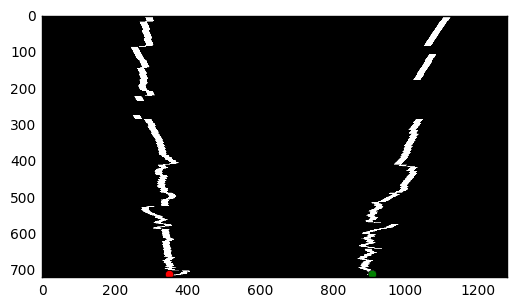

In [35]:
ml, mr = get_line_centers(histogram)
left_line  = get_line(warped, ml)
right_line = get_line(warped, mr)
lines = np.zeros_like(warped)
lines[(left_line > 0) | (right_line > 0) ] = 1
plt.plot(ml, 710, 'or')
plt.plot(mr, 710, 'og')
plt.imshow(lines, cmap='gray')

## Line Fit and projection of the lines on warped image

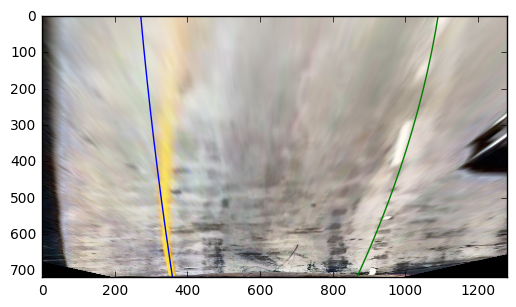

In [36]:
new_lines = cv2.warpPerspective(image, M, img_size)

yplot = np.array([x for x in range(new_lines.shape[0])])

lx, ly = x_y(left_line)
coefs_l = get_line_coefs(lx, ly)
xplot_l = fit_line(coefs_l, yplot)    
plt.plot(xplot_l, yplot)

rx, ry = x_y(right_line)
coefs_r = get_line_coefs(rx, ry)
xplot_r = fit_line(coefs_r, yplot)    
plt.plot(xplot_r, yplot)

plt.imshow(new_lines, cmap='gray')
plt.show()

In [37]:
fig = plt.figure(figsize=(20,10))
fig.add_subplot(221)
plt.plot(histogram)
plt.title('Histogram')
plt.axis('off')

fig.add_subplot(222)
plt.imshow(lines, cmap='gray')
plt.plot(ml, 710, 'or')
plt.plot(mr, 710, 'og')
plt.title('Detected lines')
plt.axis('off')

fig.add_subplot(223)
plt.imshow(new_lines)
plt.plot(xplot_l, yplot)
plt.plot(xplot_r, yplot)
plt.title('Estimated lines')
plt.axis('off')
plt.show()

fig.savefig('output_images/line_centers.jpg', bbox_inches='tight')

## Fill the area between estimated lines on original image

In [38]:
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([xplot_l, yplot]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([xplot_r, yplot])))])
pts = np.hstack((pts_left, pts_right))

cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

In [39]:
ccoefs_l = get_line_curvature_coefs(xplot_l, yplot)
ccoefs_r = get_line_curvature_coefs(xplot_r, yplot)
l_curv_text = "Curvature for left line:  {} meters".format(get_curvature(ccoefs_l, yplot[-1]))
r_curv_text = "Curvature for rigth line: {} meters".format(get_curvature(ccoefs_r, yplot[-1]))
dev_text    = "Deviation from center: {}".format(deviation_from_center(image.shape[1]/2, ml, mr))
cv2.putText(result, l_curv_text, (50,45), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
cv2.putText(result, r_curv_text, (50,70), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)
cv2.putText(result, dev_text, (50,95), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 2)

plt.imshow(result)
plt.show()

plt.imsave('output_images/result.jpg', result)

## Image Processing with a function which combines previous steps

In [40]:
image1 = mpimg.imread('test_images/test1.jpg')
plt.imshow(pipeline(image1))
plt.show()

/Users/Bombard/anaconda/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/Users/Bombard/anaconda/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


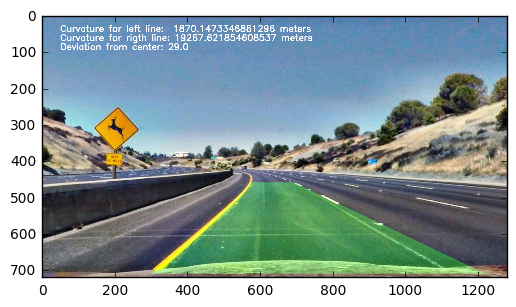

In [41]:
image2 = mpimg.imread('test_images/test2.jpg')
plt.imshow(pipeline(image2))
plt.show()

In [42]:
image3 = mpimg.imread('test_images/test3.jpg')
plt.imshow(pipeline(image3))
plt.show()

/Users/Bombard/anaconda/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [43]:
image4 = mpimg.imread('test_images/test4.jpg')
plt.imshow(pipeline(image4))
plt.show()

/Users/Bombard/anaconda/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/Users/Bombard/anaconda/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


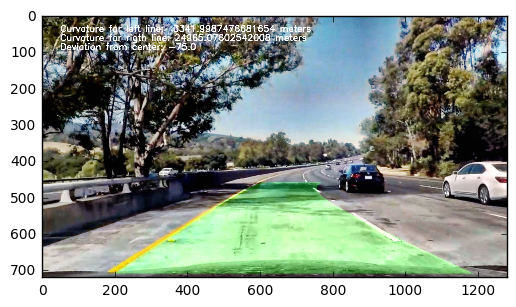

In [44]:
image5 = mpimg.imread('test_images/test5.jpg')
plt.imshow(pipeline(image5))
plt.show()

/Users/Bombard/anaconda/envs/keras/lib/python3.5/site-packages/ipykernel/__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


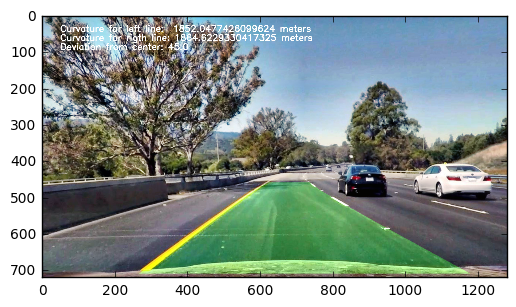

In [45]:
image6 = mpimg.imread('test_images/test6.jpg')
plt.imshow(pipeline(image6))
plt.show()